In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from inverse_modelling_tfo.tools.name_decoder import decode_extended_filename
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2, get_mu_a
from inverse_modelling_tfo.data import EQUIDISTANCE_DETECTOR_COUNT, EQUIDISTANCE_DETECTOR_PHOTON_COUNT
from tfo_sensitivity.data import load_raw

# Pre-calculated intensity using the regular formula (inner product)
maternal_wall_thickness, uterus_thickness, wave_int = 18, 5, 1
raw_sim_data_path = load_raw(maternal_wall_thickness, uterus_thickness, wave_int)
raw_sim_data = pd.read_pickle(raw_sim_data_path)
raw_sim_data['SDD'] = raw_sim_data['X'] - 100
all_sdd = raw_sim_data["SDD"].unique()
all_sdd.sort()

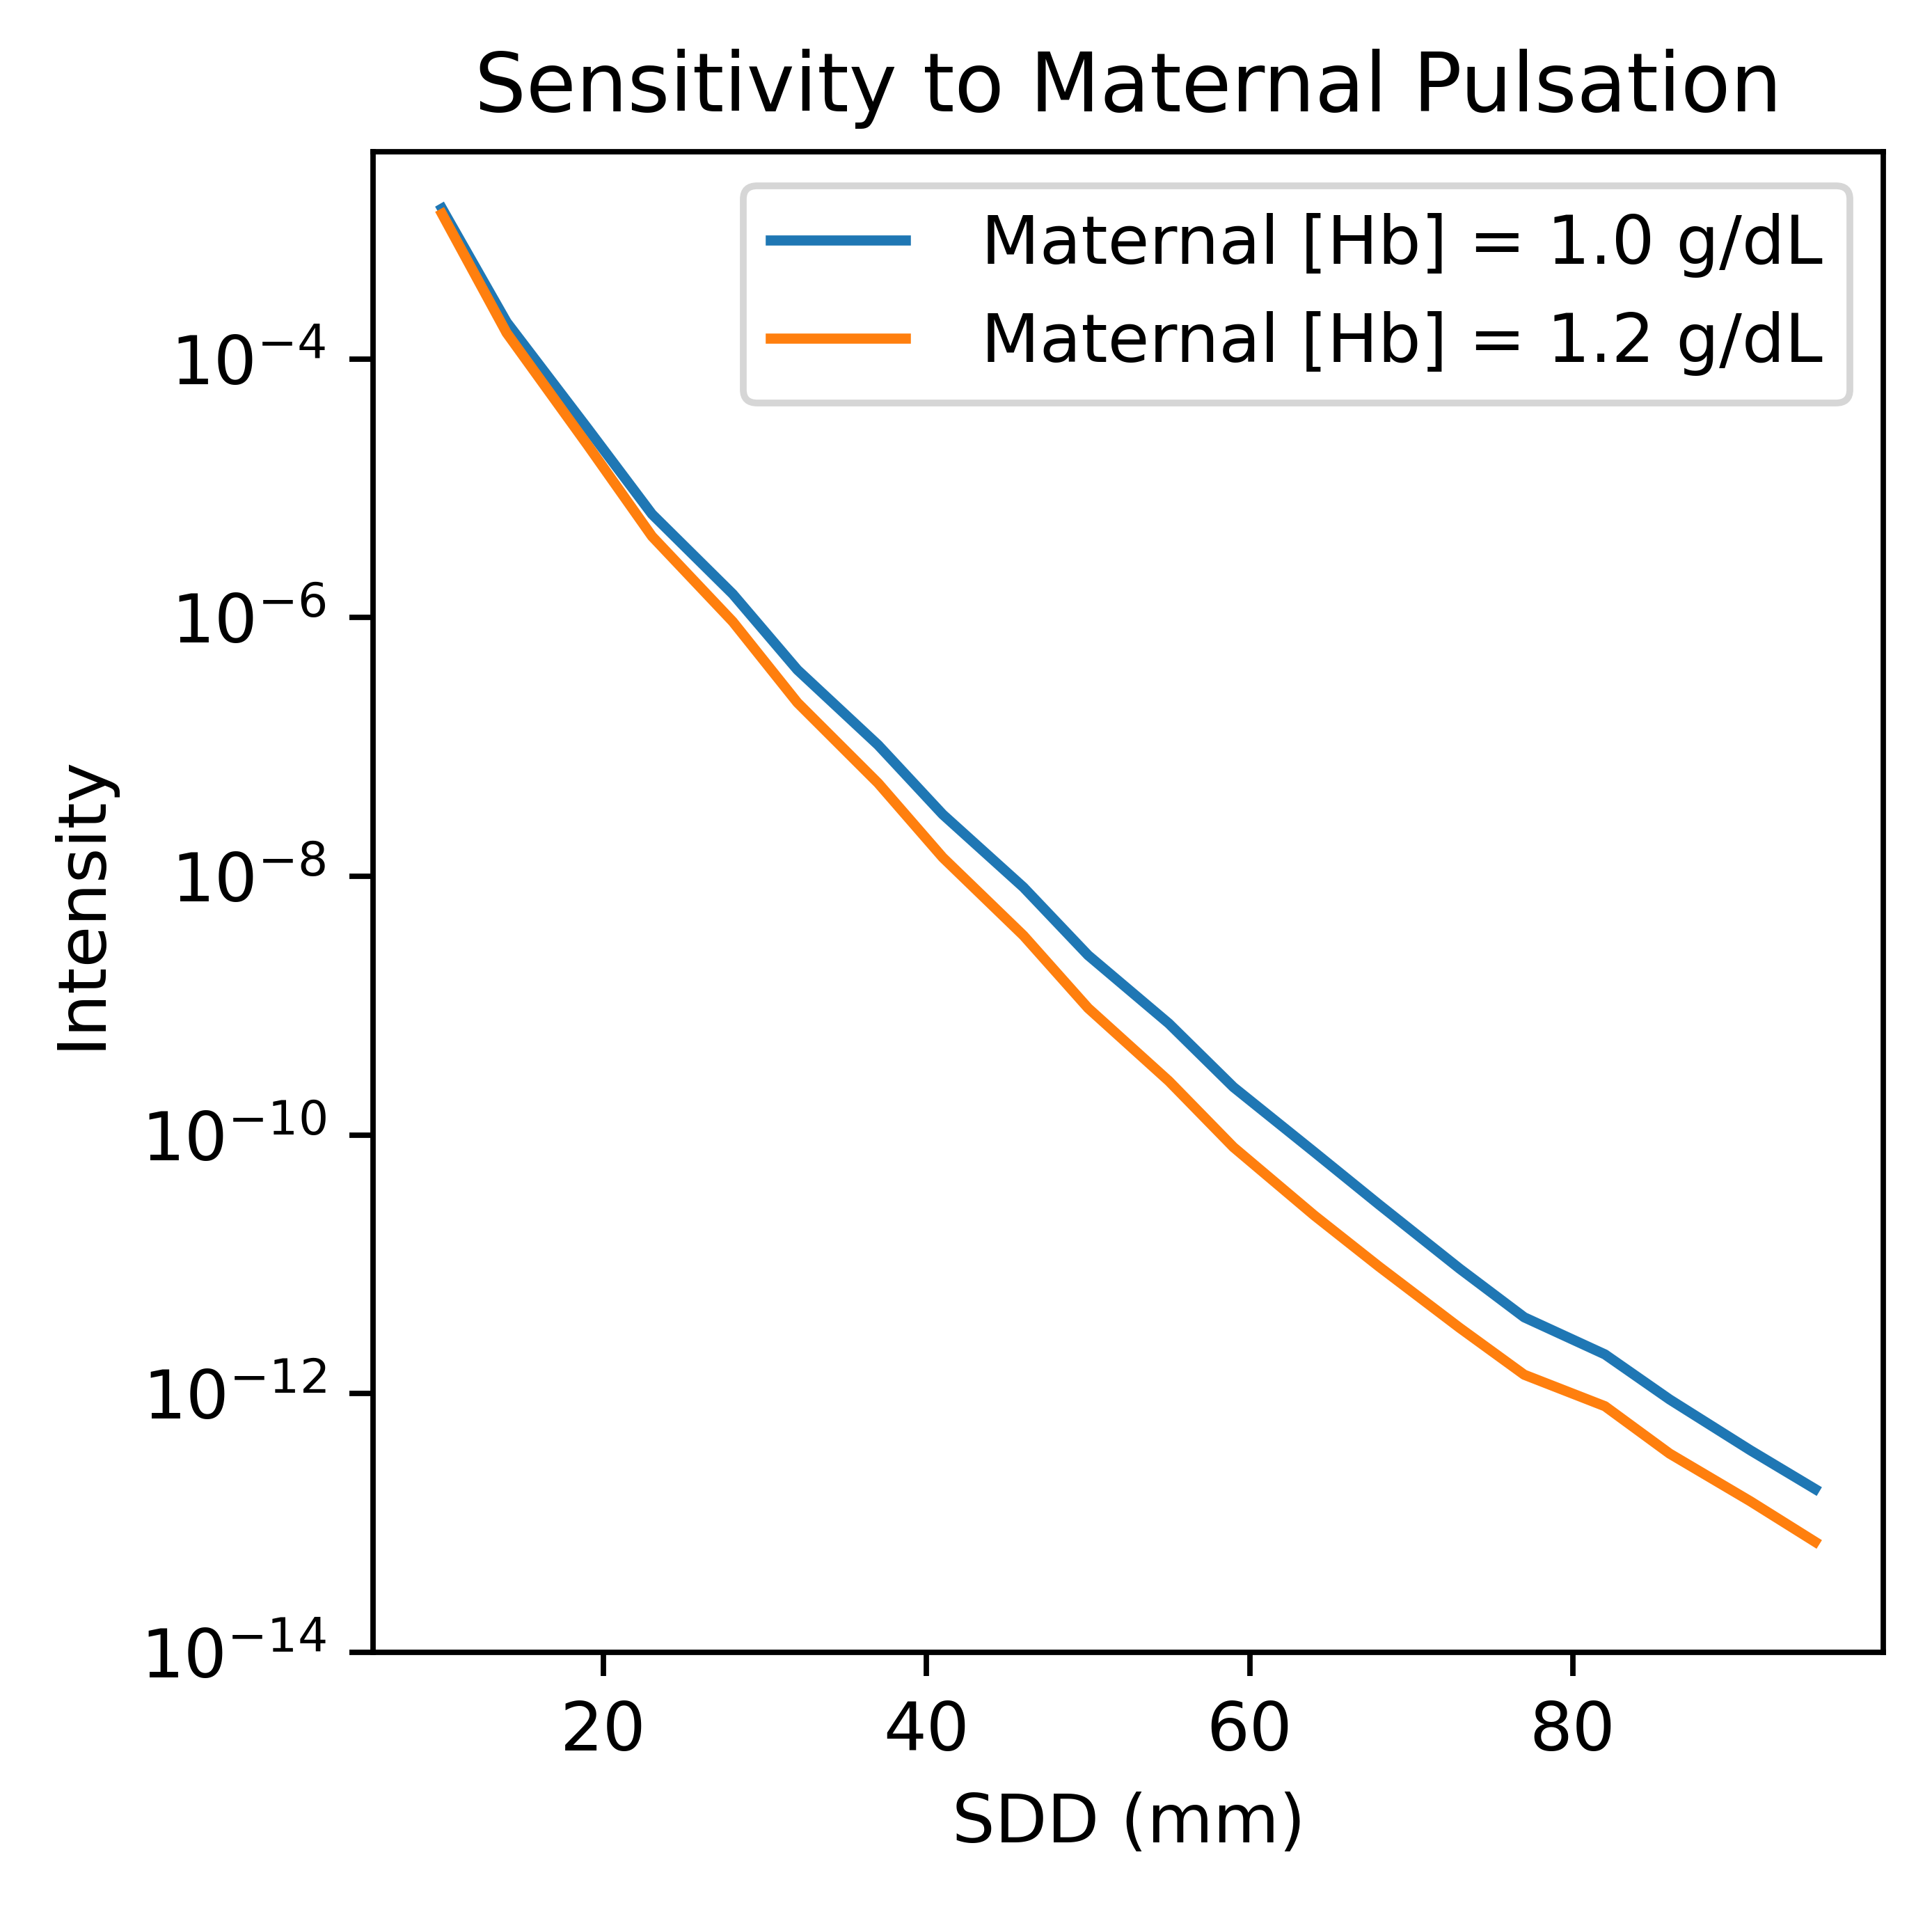

In [2]:
# Sensitivity to Maternal Pulsation
# Mu Map
FETAL_SAT = 0.6
FETAL_Hb = 1.2
MATERNAL_SAT = 1.0

modified_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2
modified_mu_map[4] = get_mu_a(FETAL_SAT, FETAL_Hb, wave_int)

all_c = [1.0, 1.2]

plt.figure(figsize=(4, 4), dpi=700)
for c in all_c:
    modified_mu_map[1] = get_mu_a(MATERNAL_SAT, c, wave_int)
    all_intensity = []
    for sdd in all_sdd:
        filtered_photon_data = raw_sim_data[raw_sim_data['SDD'] == sdd]
        G = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath']].to_numpy()
        for i in range(1, 4):
            G[:, i - 1] = np.exp(-modified_mu_map[i] * G[:, i - 1])
        G = np.prod(G, axis=1)
        A = np.exp(-modified_mu_map[4] * filtered_photon_data['L4 ppath'].to_numpy())
        intensity = np.dot(A, G)
        all_intensity.append(intensity)
    all_intensity = np.array(all_intensity)
    all_intensity /= EQUIDISTANCE_DETECTOR_COUNT
    all_intensity /= EQUIDISTANCE_DETECTOR_PHOTON_COUNT
    plt.plot(all_sdd, all_intensity, label=f' Maternal [Hb] = {c:2.1f} g/dL')

plt.title("Sensitivity to Maternal Pulsation")
plt.xlabel('SDD (mm)')
plt.ylabel('Intensity')
plt.yscale('log')
plt.ylim([1e-14, 4e-3])
plt.legend()
plt.show()

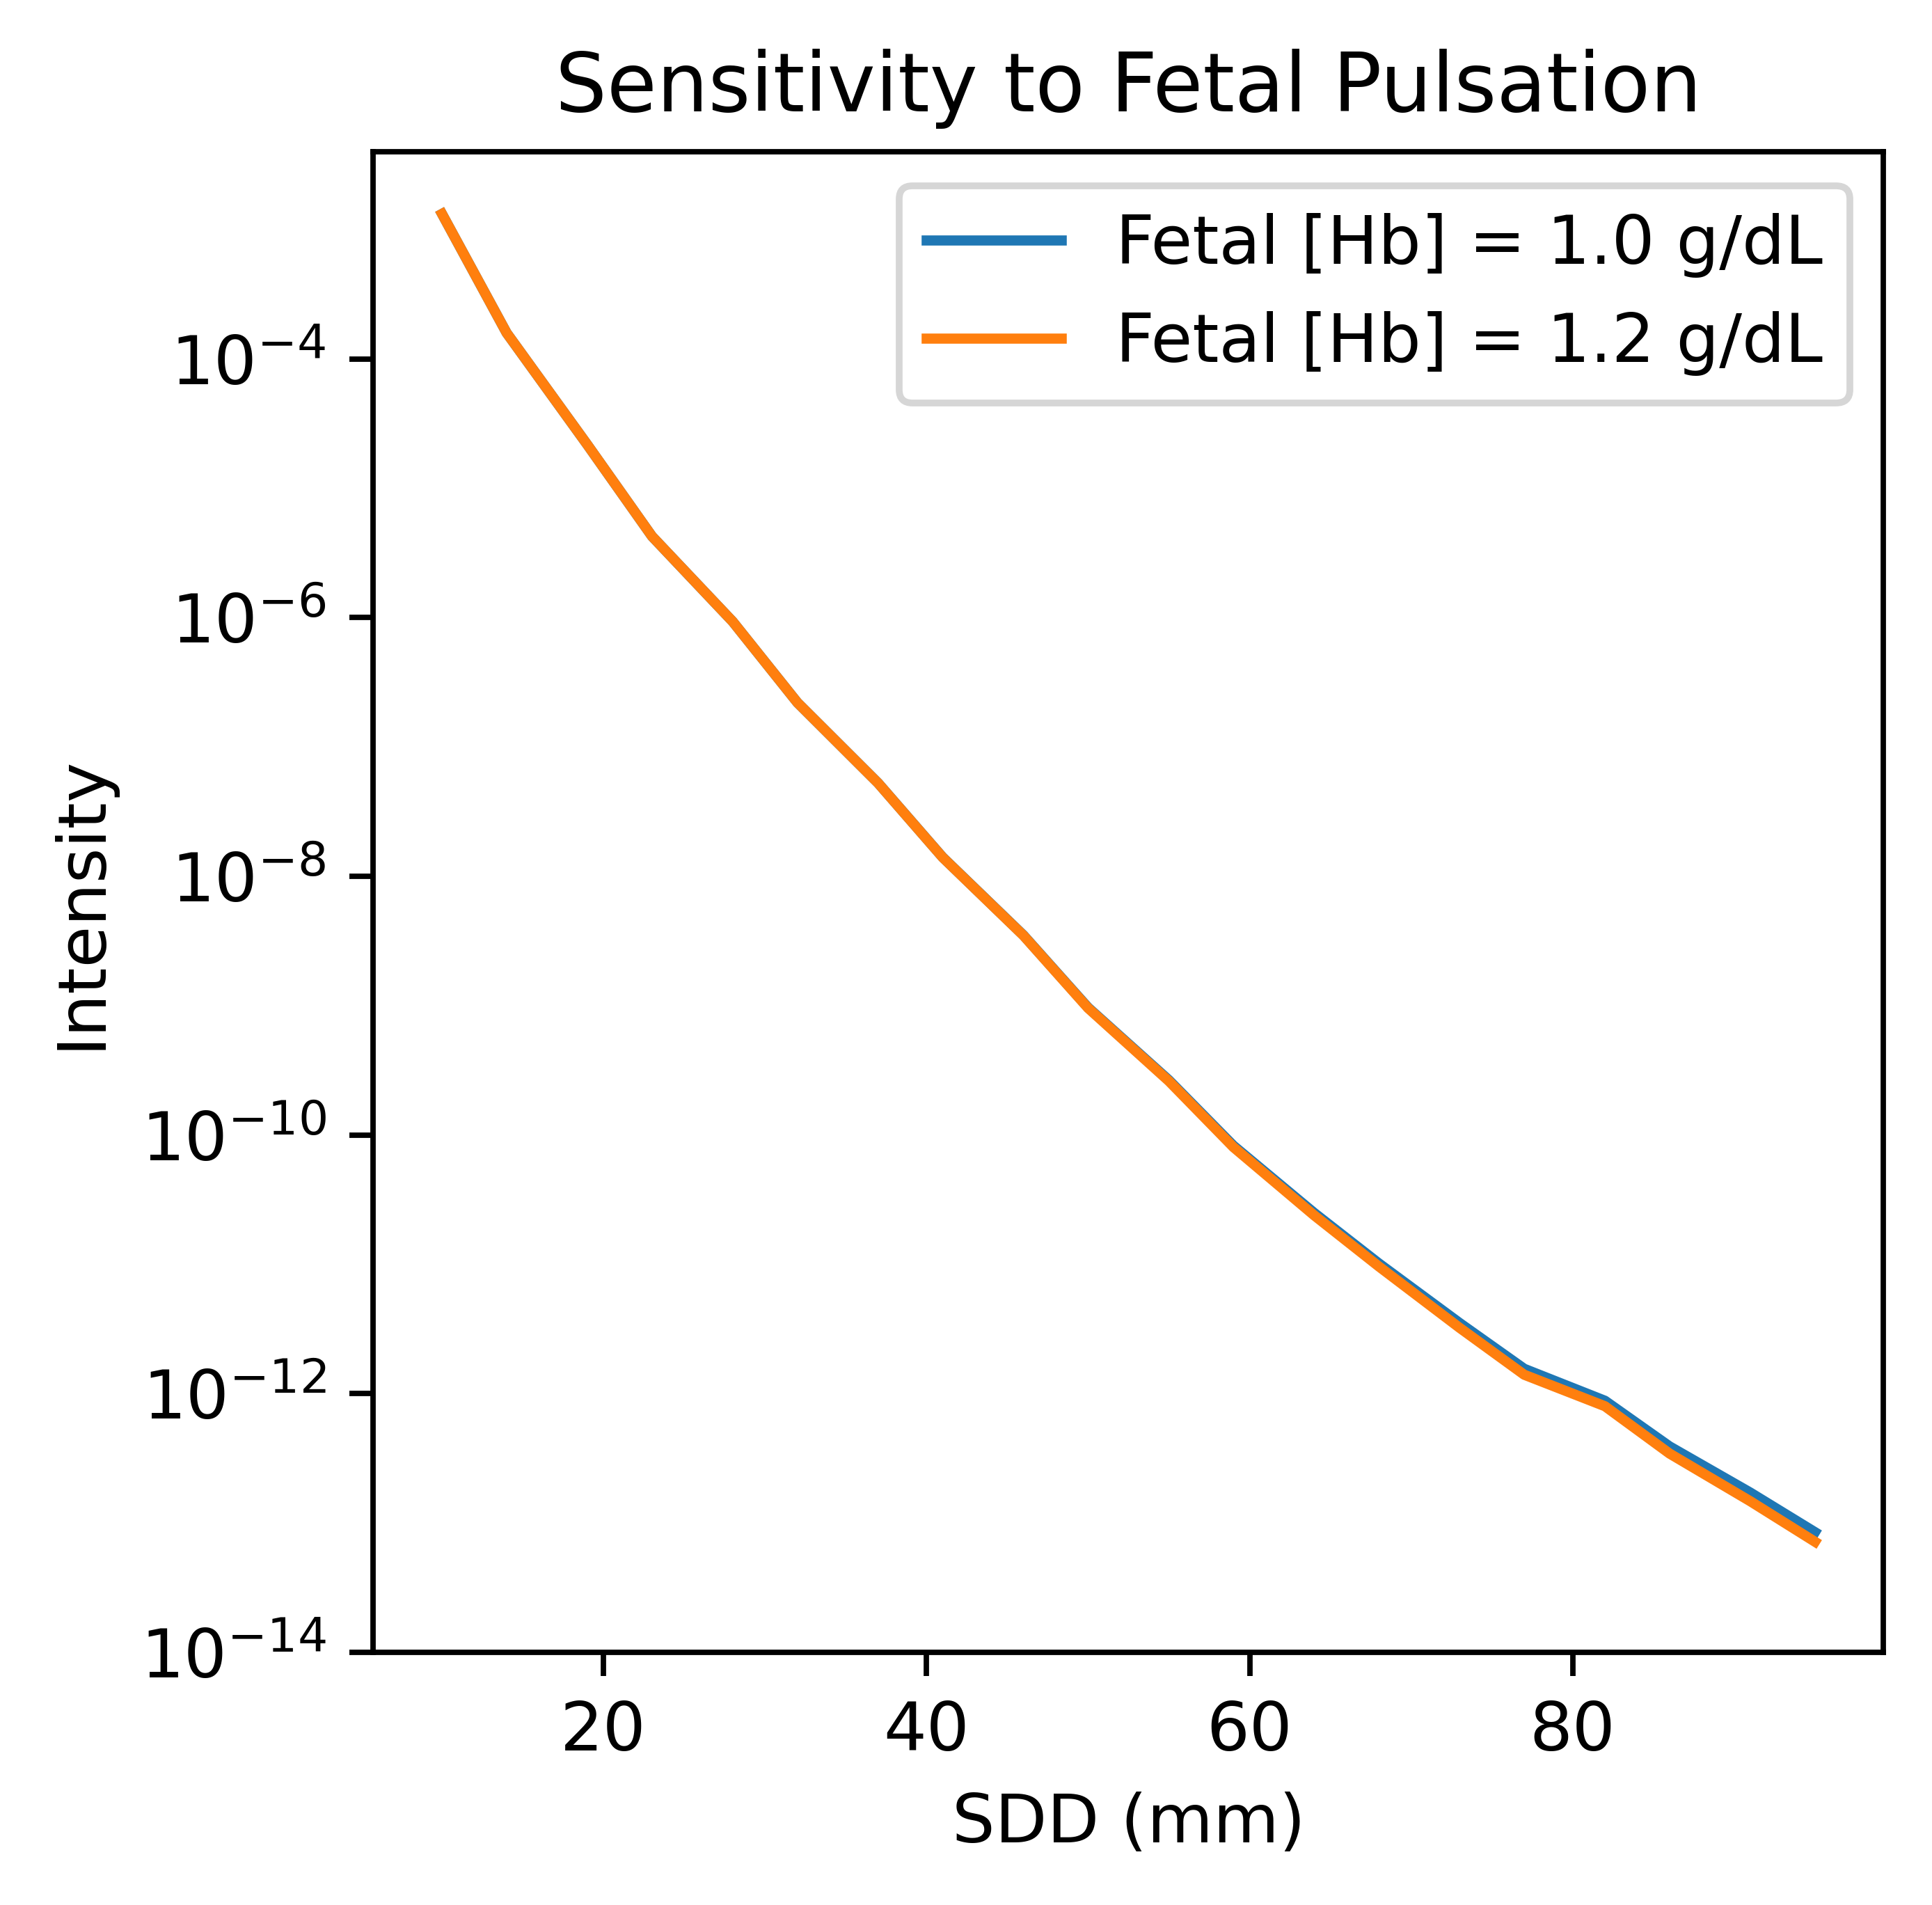

In [3]:
# Sensitivity to Fetal Pulsation
# Mu Map
FETAL_SAT = 0.6
MATERNAL_SAT = 1.0
MATERNAL_Hb = 1.2

modified_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2
modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)

plt.figure(figsize=(4, 4), dpi=700)
for c in all_c:
    modified_mu_map[4] = get_mu_a(FETAL_SAT, c, wave_int)
    all_intensity = []
    for sdd in all_sdd:
        filtered_photon_data = raw_sim_data[raw_sim_data['SDD'] == sdd]
        G = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath']].to_numpy()
        for i in range(1, 4):
            G[:, i - 1] = np.exp(-modified_mu_map[i] * G[:, i - 1])
        G = np.prod(G, axis=1)
        A = np.exp(-modified_mu_map[4] * filtered_photon_data['L4 ppath'].to_numpy())
        intensity = np.dot(A, G)
        all_intensity.append(intensity)
    all_intensity = np.array(all_intensity)
    all_intensity /= EQUIDISTANCE_DETECTOR_COUNT
    all_intensity /= EQUIDISTANCE_DETECTOR_PHOTON_COUNT
    plt.plot(all_sdd, all_intensity, label=f'Fetal [Hb] = {c:2.1f} g/dL')

plt.title("Sensitivity to Fetal Pulsation")
plt.xlabel('SDD (mm)')
plt.ylabel('Intensity')
plt.yscale('log')
plt.ylim([1e-14, 4e-3])
plt.legend()
plt.show()